In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

In [2]:
from torchvision.models import vgg16

pretrained_model = vgg16(pretrained=True)
pretrained_model.eval()
pretrained_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
feature_extractor = pretrained_model.features

In [4]:
train_dir = './augmented/TRAIN'
test_dir = './augmented/TEST'
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112,112)),
    #torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,1),
    ])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def extract_features(dataset):
    '''
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((112,112)), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    dataset = torchvision.datasets.ImageFolder(directory, transform=transform)
    '''
    batch_size = 64
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = np.zeros(shape=(len(dataset), 512, 3, 3))
    labels = np.zeros(shape=(len(dataset),))
    with torch.no_grad():
        for i, (inputs_batch, labels_batch) in enumerate(loader):
            print(i)
            inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)
            features_batch = feature_extractor(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch.cpu().numpy()
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch.cpu().numpy()

    return features, labels

train_features, train_labels = extract_features(train_dataset)
validation_features, validation_labels = extract_features(test_dataset)

0
1
2
3
4
5


KeyboardInterrupt: 

In [ ]:
train_features = np.reshape(train_features, (-1, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (-1, 3 * 3 * 512))

In [6]:
feature_classifier = nn.Sequential(
    nn.Linear(3*3*512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

feature_classifier.to(device)

Sequential(
  (0): Linear(in_features=4608, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=1, bias=True)
  (4): Sigmoid()
)

In [ ]:
optimizer = optim.Adam(feature_classifier.parameters(), lr=0.001, weight_decay = 0.001)
loss_fn = nn.BCELoss()

In [20]:
from torch.utils.data import TensorDataset

batch_size = 64
train_features_dataset = TensorDataset(torch.tensor(train_features), torch.tensor(train_labels))
train_features_loader = DataLoader(train_features_dataset, batch_size=batch_size, shuffle=True)

val_features_dataset = TensorDataset(torch.tensor(validation_features), torch.tensor(validation_labels))
val_features_loader = DataLoader(val_features_dataset, batch_size=batch_size, shuffle=False)

NameError: ignored

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def precision_and_recall(conf_matrix):
    '''
    0: covid
    1: no covid

    11 12
    21 22
   

    precision = positivos reportados correctamente / positivos reportados
    recall = positivos reportados correctamente /positivos totales
    '''
    true_pos = conf_matrix[0,0].sum()
    reported_pos = conf_matrix[:,0].sum()
    total_pos = conf_matrix[0,:].sum()
    precision = true_pos/reported_pos
    recall = true_pos/total_pos
    return precision, recall


def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs):

    train_accuracies, train_losses, train_precisions, train_recalls, val_accuracies, val_losses, val_precisions, val_recalls = [],[],[],[],[],[],[],[]
    val_loss = AverageMeter()
    val_accuracy = AverageMeter()
    train_loss = AverageMeter()
    train_accuracy = AverageMeter()
    
    

    for epoch in range(epochs):
        # train
        model.train()
        train_loss.reset()
        train_accuracy.reset()

        train_conf_matrix = np.zeros((2,2))

        train_loop = tqdm(train_loader, unit=" batches")  # For printing the progress bar
        for data, target in train_loop:
            train_loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, epochs))
            data, target = data.float().to(device), target.float().to(device)
            target = target.unsqueeze(-1)
            optimizer.zero_grad()
            output = model(data)
            #print(output.shape,target.shape,output,target,len(output),target.view(-1).shape)
            loss = loss_fn(output, target)
            
            weight = torch.tensor([0.9, 0.1])
            weight_ = weight[target.data.view(-1).long()].view_as(target)

            loss_class_weighted = loss * weight_
            loss_class_weighted = loss_class_weighted.mean()
            
            loss_class_weighted.backward()
            optimizer.step()

            train_loss.update(loss.item(), n=len(target))
            #pred = output.round() # get the prediction
            pred = [0 if i<0.8 else 1 for i in output]
            pred = torch.FloatTensor(pred)  # convert list to tensor
            acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
            train_accuracy.update(acc, n=len(target))
            train_conf_matrix = train_conf_matrix + confusion_matrix(target.detach().numpy(),pred.detach().numpy(),labels = [0,1])

            #Update the progress_bar
            train_loop.set_postfix(loss=train_loss.avg, accuracy=train_accuracy.avg)

        train_losses.append(train_loss.avg)
        train_accuracies.append(train_accuracy.avg)
    
        prec, recall = precision_and_recall(train_conf_matrix)
        train_precisions.append(prec)
        train_recalls.append(recall)

        # validation
        model.eval()
        val_loss.reset()
        val_accuracy.reset()

        validation_conf_matrix = np.zeros((2,2))

        val_loop = tqdm(val_loader, unit=" batches")  # For printing the progress bar
        with torch.no_grad():
            for data, target in val_loop:
                val_loop.set_description('[VAL] Epoch {}/{}'.format(epoch + 1, epochs))
                data, target = data.float().to(device), target.float().to(device)
                target = target.unsqueeze(-1)
                output = model(data)
                loss = loss_fn(output, target)
                val_loss.update(loss.item(), n=len(target))
                #pred = output.round() # get the prediction
                pred = [0 if i<0.8 else 1 for i in output]
                pred = torch.FloatTensor(pred)
                acc = pred.eq(target.view_as(pred)).sum().item()/len(target)
                val_accuracy.update(acc, n=len(target))
                validation_conf_matrix = validation_conf_matrix + confusion_matrix(target.detach().numpy(),pred.detach().numpy(),labels = [0,1])

                val_loop.set_postfix(loss=val_loss.avg, accuracy=val_accuracy.avg)

        val_losses.append(val_loss.avg)
        val_accuracies.append(val_accuracy.avg)

        prec, recall = precision_and_recall(validation_conf_matrix)
        val_precisions.append(prec)
        val_recalls.append(recall)
        
    return train_accuracies, train_losses, train_precisions, train_recalls, val_accuracies, val_losses, val_precisions, val_recalls

In [ ]:
epochs = 60
train_accuracies, train_losses, train_precisions, train_recalls, val_accuracies, val_losses, val_precisions, val_recalls = train_model(feature_classifier, optimizer, loss_fn, train_features_loader, val_features_loader, epochs)



[VAL] Epoch 60/60: 100%|██████████| 12/12 [00:00<00:00, 76.15 batches/s, accuracy=0.922, loss=0.251]


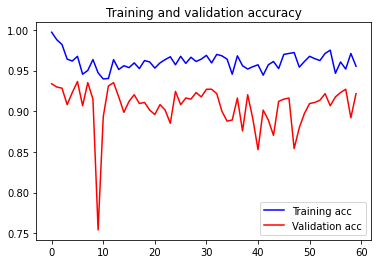

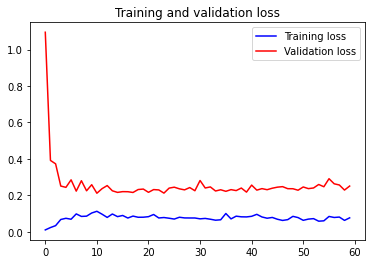

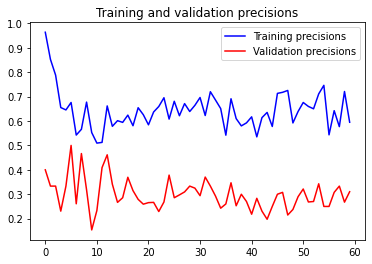

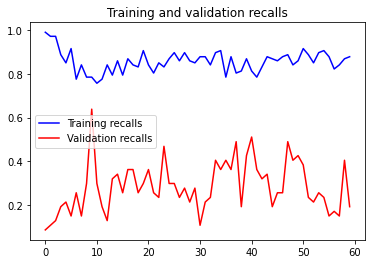

In [ ]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_precisions, 'b', label='Training precisions')
plt.plot(epochs, val_precisions, 'r', label='Validation precisions')
plt.title('Training and validation precisions')
plt.legend()

plt.figure()

plt.plot(epochs, train_recalls, 'b', label='Training recalls')
plt.plot(epochs, val_recalls, 'r', label='Validation recalls')
plt.title('Training and validation recalls')
plt.legend()

plt.show()

In [ ]:
# a partir d'aqui: FINE TUNING

In [8]:
pretrained_model = vgg16(pretrained=True)
pretrained_model.to(device)
feature_extractor = pretrained_model.features
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
for layer in feature_extractor[:24]:  # Freeze layers 0 to 23
    for param in layer.parameters():
        param.requires_grad = False

for layer in feature_extractor[24:]:  # Train layers 24 to 30
    for param in layer.parameters():
        param.requires_grad = True

In [10]:
model = nn.Sequential(
    feature_extractor,
    nn.Flatten(),
    feature_classifier
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
train_dir = './augmented/TRAIN'
test_dir = './augmented/TEST'
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112,112)),
    #torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,1),
    ])

batch_size = 64

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
optimizer = optim.Adam(feature_classifier.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [13]:
epochs = 2
train_accuracies, train_losses, train_precisions, train_recalls, val_accuracies, val_losses, val_precisions, val_recalls = train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs)



[VAL] Epoch 2/2: 100%|██████████| 15/15 [01:54<00:00,  6.65s/ batches, accuracy=0.831, loss=0.286]


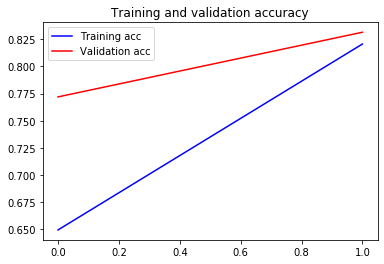

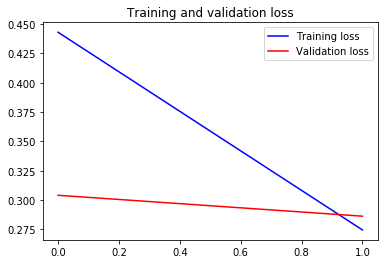

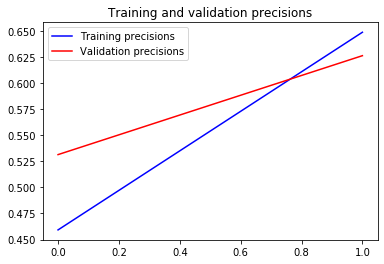

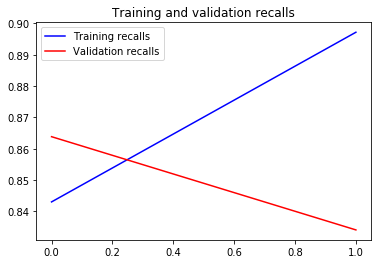

In [14]:
epochs = range(len(train_accuracies))

plt.plot(epochs, train_accuracies, 'b', label='Training acc')
plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_precisions, 'b', label='Training precisions')
plt.plot(epochs, val_precisions, 'r', label='Validation precisions')
plt.title('Training and validation precisions')
plt.legend()

plt.figure()

plt.plot(epochs, train_recalls, 'b', label='Training recalls')
plt.plot(epochs, val_recalls, 'r', label='Validation recalls')
plt.title('Training and validation recalls')
plt.legend()

plt.show()

In [15]:
torch.save(model, './models/fine_tuned_transfer_augmented.pt')

In [ ]:
# stride > 1
# L2: optimizer = optim.Adam(bignet.parameters(), lr=hparams['learning_rate'], weight_decay=0.001) [canviar nom model]
# Dropout: nn.Dropout(p) después del flatten

In [ ]:
# Gaussian noise for data augmentation

In [ ]:
# Data augmentation audio

In [ ]:
'''
separar una tos en varias toses
resamplear -> cambiar la freq de muestreo
quitar tramos de silencio
precission, recall, sensitivity sobretot [CONFUSION MATRIX] -> que ningún positivo se cuele (min falso negativo)
'''